# Transformer Architecture

Transformer architecture has taken the world by storm. It is the engine behind most impressive large language models today. The key component of success of this architecture is its ability to process information across wide span of context. Researchers were able to scale this architecture to bilions or even trilions of parameters and empirically showed that it can provide superior understanding of written text.

A key component of the transformer architecture is the self-attention mechanism. It is the exact module that allows the features of long inputs to communicate and pass information to each other. Thus, transformer architecture is able to:

1. Understand relationships between tokens in the input
2. Process large sequences without loss of information

We will implement the whole transformer step by step to understand it.

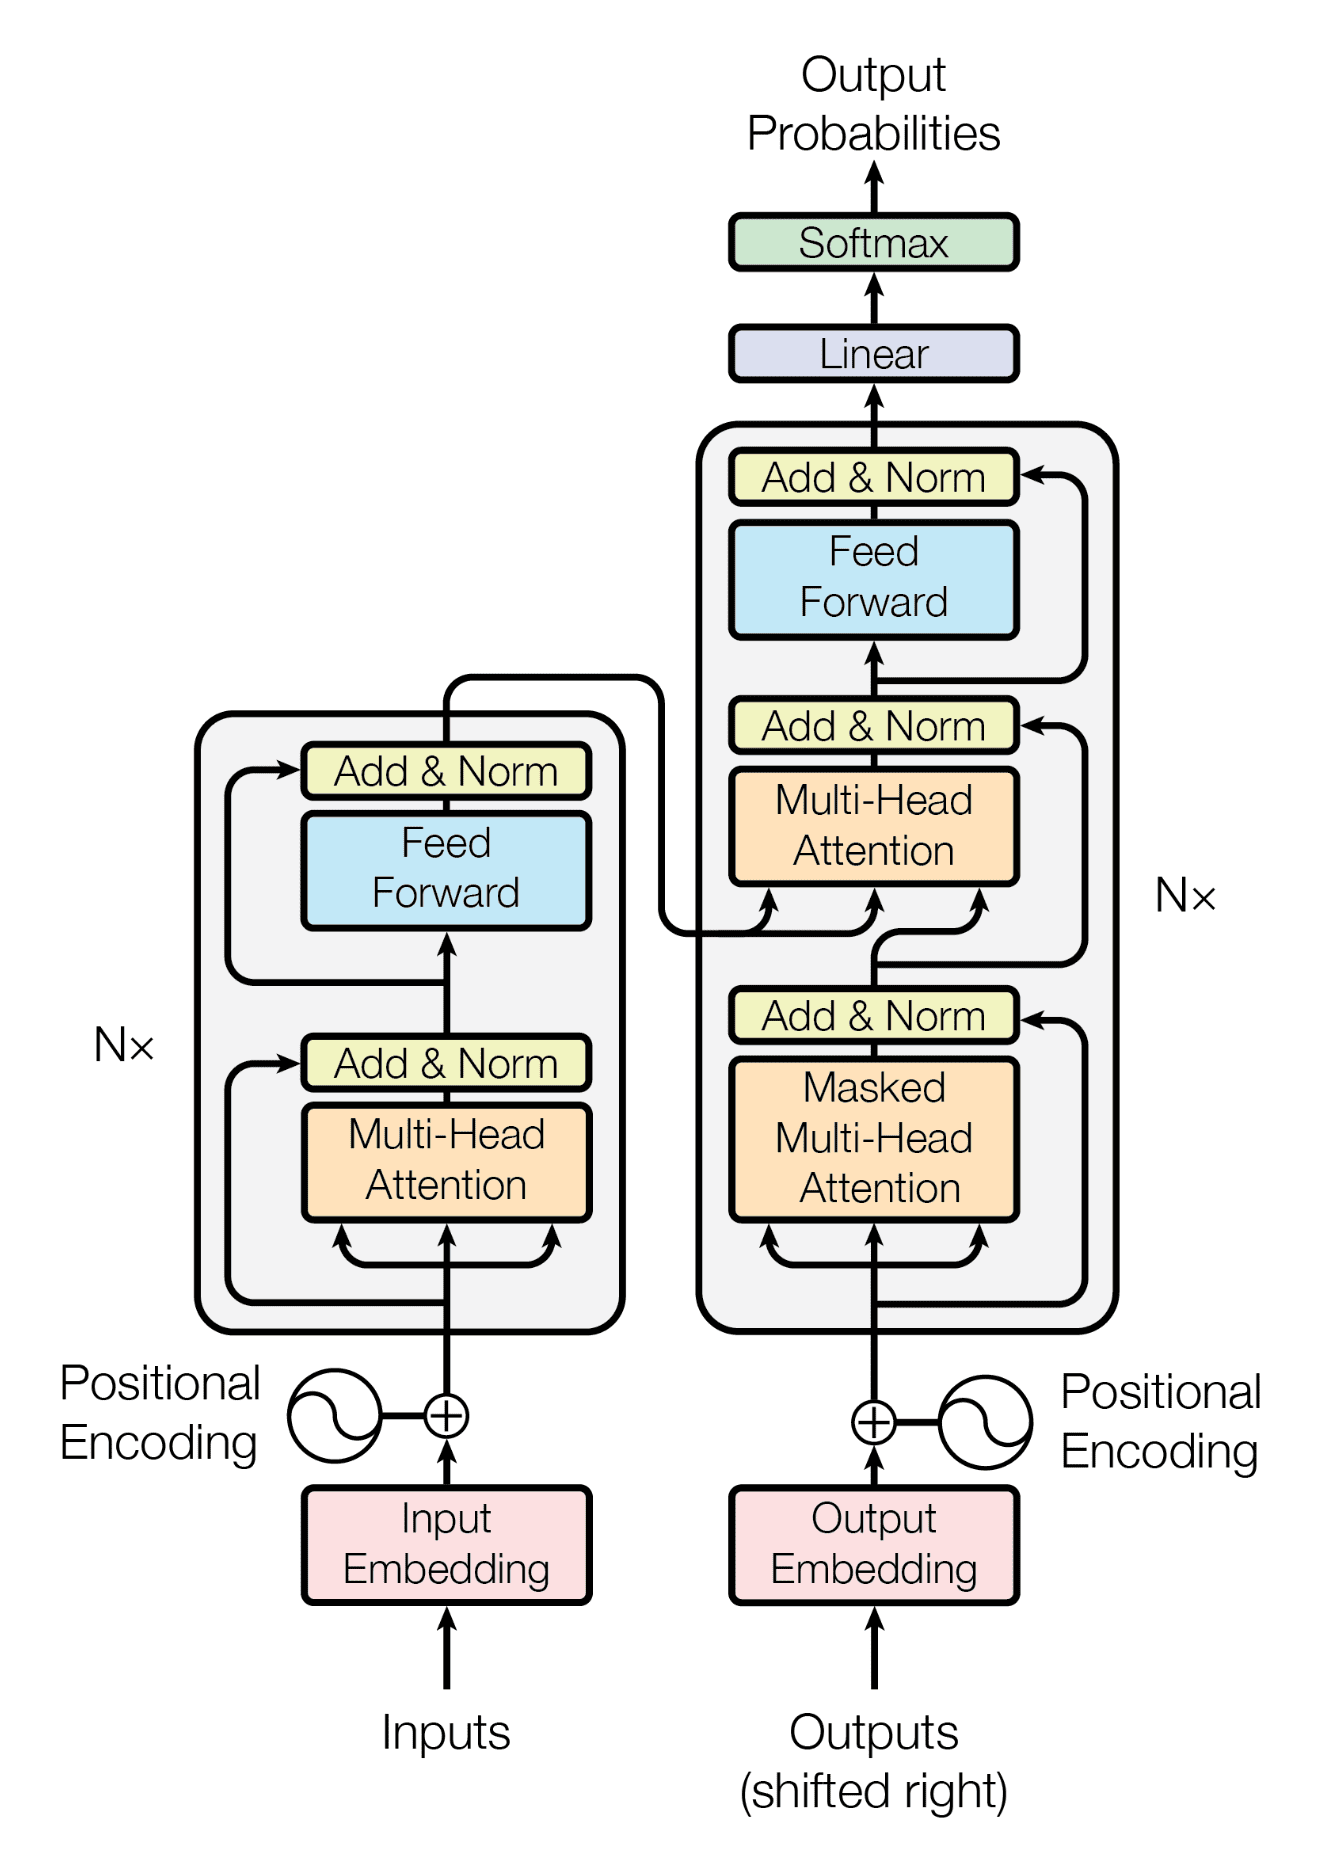

# Preliminaries

Install the dependencies below.

In [ ]:
import os
from os.path import exists
import torch
import torch.nn as nn
import math
from typing import Optional
import torch.nn.functional as F
from dataclasses import dataclass
import spacy
import torchtext
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.functional import pad
import time

torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 1. Embeddings

Implement both the token embeddings and positional encoding. Use Sinusoidal positional embeddings like in the original Transformer paper

In [2]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, self.d_model)


    def forward(self, x: torch.Tensor):
        return self.embedding(x) *  math.sqrt(self.d_model)



class PosEmbedding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, drop_p: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(drop_p)

        # Make the model to understand the position of each token
        # Define the positional embeddings using sine and cosine functions of different frequencies

        pe = torch.zeros(max_len, d_model) 
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
    
        # Register
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor):
        # YOUR CODE HERE
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [3]:
tok_emb_layer = TokenEmbedding(32, 512)
pos_emb_layer = PosEmbedding(512, 10)

x = torch.tensor([[1, 2, 2, 5]])

output = pos_emb_layer(tok_emb_layer(x))
assert output.shape == torch.Size([1, 4, 512]), "Ensure that you are embedding input ids into correct dimensions"

## 2. Layer Normalization

Implement the layer normalization

In [4]:
class LayerNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()

        # TODO: Implement the Layer Norm layer
        # YOUR CODE HERE
        self.g = nn.Parameter(torch.ones(dim))
        self.b = nn.Parameter(torch.zeros(dim))
        self.eps = eps


    def forward(self, x: torch.Tensor):
        # YOUR CODE HERE
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.g*(x - mean)/(std+self.eps) + self.b



In [5]:
pytorch_norm = nn.LayerNorm(32, eps=1e-8)
our_norm = LayerNorm(32, eps=1e-8)

x = torch.randn(1, 32)

# These should be close to each other
print(pytorch_norm(x), our_norm(x))

assert our_norm(x).shape == x.shape, "Ensure your normalization doesn't break dimensions of the input"

tensor([[ 1.1843,  0.1705, -0.2699,  0.0752,  0.7970,  0.1840,  2.3179,  0.7858,
          0.7898,  0.1928,  0.1753, -1.3635,  1.1916, -0.2724, -0.0397, -0.1911,
         -1.0559, -0.2619, -0.6669, -1.6842, -0.6901,  1.0622, -1.0399, -0.0093,
          0.8562,  0.6313,  0.3177, -0.2494,  0.4958, -0.1358, -3.3222,  0.0249]],
       grad_fn=<NativeLayerNormBackward0>) tensor([[ 1.1657,  0.1679, -0.2657,  0.0740,  0.7844,  0.1811,  2.2814,  0.7734,
          0.7774,  0.1898,  0.1725, -1.3420,  1.1729, -0.2681, -0.0391, -0.1881,
         -1.0393, -0.2578, -0.6564, -1.6576, -0.6793,  1.0455, -1.0236, -0.0091,
          0.8427,  0.6213,  0.3127, -0.2454,  0.4880, -0.1337, -3.2699,  0.0245]],
       grad_fn=<AddBackward0>)


## 3. Multi Head Attention

In this part. You will be implementing multi head attention. Below are several functions and classes that you need

### Causal Mask

Transformer's often need to mask their inputs to prevent ground truth leakage. Implement a function to mask future tokens for any given position

In [6]:
def causal_mask(attn_size: int):
    # Implement Causal masking that masks future tokens in attention
    attn_shape = (1, attn_size, attn_size)
    mask = torch.tril(torch.ones(attn_shape)).type(torch.uint8)

    return mask

In [7]:
mask = causal_mask(8)

# Verify that this is a lower triangular matrix with 0s and 1s
mask

tensor([[[1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1]]], dtype=torch.uint8)

### Scaled dot product attention.

Implement the scaled dot product attention function. It receives, (q, k, v) triplets, a mask and a dropout probability.

Make sure to return the attention result and normalized attention matrix with it as a tuple (attn, attn_p)

In [8]:
def scaled_dot_product_attention(
    q: torch.Tensor,  # bs, num_heads, seq_len, d
    k: torch.Tensor,  # bs, num_heads, seq_len, d
    v: torch.Tensor,  # bs, num_heads, seq_len, d
    mask: Optional[torch.Tensor] = None, # 1, 1, attn_dim, attn_dim
    drop_p: float = 0.1
):
    # TODO: Compute scaled dot product self attention
    # Do not forget to apply the mask to the attention matrix if it is present

    # Return both the attention result and the normalized attention matrix as a tuple (attn, attn_p)

    # YOUR CODE HERE
    d_k = q.size(-1)
    
    att_score = torch.matmul(q, k.transpose(-1,-2)) / math.sqrt(d_k)
    if mask is not None:
        att_score = att_score.masked_fill(mask == 0, float('-inf'))
    att_prob = F.softmax(att_score, dim = -1)
    
    dropout = nn.Dropout(drop_p)
    attn_p = dropout(att_prob)
    
    attn= torch.matmul(attn_p,v)
    
    return attn, attn_p
    


In [9]:
bs, seq_len, n_heads, d_k = 32, 10, 8, 64

Q = torch.randn(bs, n_heads, seq_len, d_k)
K = torch.randn(bs, n_heads, seq_len, d_k)
V = torch.randn(bs, n_heads, seq_len, d_k)

attn_p, attn = scaled_dot_product_attention(Q, K, V, drop_p=0)

pytorch_attn = torch.nn.functional.scaled_dot_product_attention(Q, K, V, dropout_p=0)

# You should get a very small number here
print((attn_p - torch.nn.functional.scaled_dot_product_attention(Q, K, V, dropout_p=0)).sum())
assert torch.allclose(attn_p, pytorch_attn, atol=1e-5, rtol=1e-5), "Your implementation differs too much from PyTorch's"

# the normalized attention matrix
assert attn.shape == torch.Size([32, 8, 10, 10]), "Esnure that the attention matrix has correct dimensions"

tensor(-1.1460e-06)


### Multi Head Attention

Using the scaled dot product attention, compute Multi Head Attention. First, define all the necessary layers for attention. Then, write the forward pass

In [40]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self,
        d_model: int,
        num_h: int,
        drop_p: float = 0.1
    ):
        super().__init__()

        # TODO: Implement Multi Head Attention

        # Hint: Cache the normalized attention matrix from scale_dot_product_attention
        # for visualisation purposes

        self.attn = None # Save attention matrix here

        self.d_k = d_model // num_h
        self.num_h = num_h
        self.proj_q = nn.Linear(d_model, d_model)
        self.proj_k = nn.Linear(d_model, d_model)
        self.proj_v = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.drop_p = drop_p

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.Tensor = None,
    ):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)

        # YOUR CODE HERE
        
        bs, seq_len, _ = query.size()
        
        query = query.view(bs, -1, self.num_h, self.d_k).transpose(1,2)
        key = key.view(bs, -1, self.num_h, self.d_k).transpose(1,2)
        value = value.view(bs, -1, self.num_h, self.d_k).transpose(1,2)

        query = self.proj_q(query).view(bs, -1, self.num_h, self.d_k).transpose(1,2)
        key = self.proj_k(key).view(bs, -1, self.num_h, self.d_k).transpose(1,2)
        value = self.proj_v(value).view(bs, -1, self.num_h, self.d_k).transpose(1,2)
        
        res, self.attn = scaled_dot_product_attention(query,key,value,mask = mask, drop_p= self.drop_p)
        
        res = res.transpose(-2,-3).reshape(bs,seq_len,self.d_k * self.num_h)
        
        return res
        
        

In [41]:
bs, seq_len, d_model = 32, 10, 128
mha = MultiHeadAttention(128, 2, 0)

Q = torch.randn(bs, seq_len, d_model)
K = torch.randn(bs, seq_len, d_model)
V = torch.randn(bs, seq_len, d_model)

output = mha(Q, K, V)

assert output.shape == torch.Size([32, 10, 128]), "Ensure that the attention result has correct dimensions"
assert mha.attn.shape == torch.Size([32, 2, 10, 10]), "Ensure that the attention matrix has correct dimensions"

## 4. Position-Wise Feed Forward Network

Implement the position-wise feed forward layer

In [12]:
class FeedForward(nn.Module):
    def __init__(
        self,
        d_model: int,
        d_ffn: int,
        drop_p: float = 0.1
    ):
        super().__init__()

        # TODO: Implement the Feed Forward layer
        self.linear1 = nn.Linear(d_model,d_ffn)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ffn,d_model)
        self.dropout = nn.Dropout(drop_p)
        # YOUR CODE HERE

    def forward(self, x):
        # YOUR CODE HERE
        return self.linear2(self.dropout(self.relu(self.linear1(x))))


In [13]:
ffn = FeedForward(512, 1024, 0)
output = ffn(torch.randn(1, 512))

assert output.shape == torch.Size([1, 512]), "Ensure that ffn outputs correct amount of neurons"

## 5. The Encoder and the Decoder

Using all the blocks you created above, define a single encoder and decoder layes. Each layer will perform attention (or multiple of them) with a skip connection followed by feed forward layer.

In [42]:
class EncoderLayer(nn.Module):
    def __init__(
        self,
        d_model: int = 512,
        num_h: int = 8,
        d_ffn: int = 1024,
        drop_p: float = 0.1,
    ):
        super().__init__()

        """
        TODO: Implement a single Encoder layer of the Transformer

        It should contain a multi head attention block
        A feed forward block
        Layer Normalization
        Dropout
        Skip connections: Ie. y = x + (f(x)), the input is added back to the output
        """

        self.multi_head_attention = MultiHeadAttention(d_model=d_model, num_h=num_h, drop_p=drop_p)
        self.ffn = FeedForward(d_model, d_ffn, drop_p=drop_p)
        self.norm_attn = LayerNorm(d_model)
        self.drop_attn = nn.Dropout(drop_p)
        self.norm_ffn = LayerNorm(d_model)
        self.drop_ffn = nn.Dropout(drop_p)

    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ):

        # Norm + MHA + Dropout + Skip connection
        
        out_attn = self.drop_attn(self.multi_head_attention(x, x, x, mask)) + x
        out_attn = self.norm_attn(out_attn)

        # Norm + FFN + Dropout + Skip connection
        out_ffn = self.drop_ffn(self.ffn(out_attn)) + out_attn
        out_ffn = self.norm_ffn(out_attn)

        return out_ffn

In [43]:
enc = EncoderLayer()
x = torch.randn(1, 10, 512)
output = enc(x)

assert output.shape == torch.Size([1, 10, 512]), "Ensure that your encoder layer outputs correct number of units"

In [44]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        d_model: int = 512,
        num_h: int = 8,
        d_ffn: int = 1024,
        drop_p: float = 0.1,
    ):
        super().__init__()

        """
        TODO: Implement a single Encoder layer of the Transformer

        It should contain
        A multi head causal attention block
        A multi head cross attention block
        A feed forward block
        Layer normalization
        Dropout
        Skip connections: Ie. y = x + (f(x)), the input is added back to the output
        """
        self.causal_attention = MultiHeadAttention(d_model=d_model, num_h=num_h, drop_p=drop_p)
        self.cross_attention = MultiHeadAttention(d_model=d_model, num_h=num_h, drop_p=drop_p)
        self.ffn = FeedForward(d_model, d_ffn, drop_p=drop_p)

        self.norm_causal = LayerNorm(d_model)
        self.drop_causal = nn.Dropout(drop_p)
        self.norm_cross = LayerNorm(d_model)
        self.drop_cross = nn.Dropout(drop_p)
        self.norm_ffn = LayerNorm(d_model)
        self.drop_ffn = nn.Dropout(drop_p)

    def forward(
        self,
        x: torch.Tensor,
        memory: torch.Tensor,
        src_mask: Optional[torch.Tensor] = None,
        tgt_mask: Optional[torch.Tensor] = None,
    ):

        # Norm + Causal Attention + Dropout + Skip connection
        out_attn = self.drop_causal(self.causal_attention(x, x, x, tgt_mask)) + x
        out_attn = self.norm_causal(out_attn)

        # Norm + Cross Attention + Dropout + Skip connection

        out_cross_attn = self.drop_cross(self.cross_attention(out_attn, memory, memory, src_mask)) + out_attn
        out_cross_attn = self.norm_cross(out_cross_attn)
        # Norm + FFN + Dropout + Skip connection
        # YOUR CODE HERE

        out_ffn = self.drop_ffn(self.ffn(out_cross_attn)) + out_cross_attn
        out_ffn = self.norm_ffn(out_ffn)

        return out_ffn

In [45]:
dec = DecoderLayer()
x = torch.randn(1, 10, 512)
mem = torch.randn(1, 10, 512)

output = dec(x, mem)
assert output.shape == torch.Size([1, 10, 512]), "Ensure that your decoder outputs"

## 5. The Generator (Last place to write your code)

After computing the forward pass of the transformer, we need to obtain log probabilities. Complete the class below to obtain the scores and apply log softmax to them

In [46]:
class Generator(nn.Module):
    def __init__(
        self,
        out_size: int,
        d_model: int = 512,
    ):
        super().__init__()
        self.proj = nn.Linear(d_model, out_size)

    def forward(self, x: torch.Tensor):
        # TODO: Implement the output layer
        # Use log_softmax instead of softmax for the final activation to get the log_probs

        # YOUR CODE HERE
        return torch.log_softmax(self.proj(x), dim = -1)


In [47]:
gen = Generator(1000, 512)
x = torch.randn(1, 10, 512)

output = gen(x)

assert output.shape == torch.Size([1, 10, 1000]), "Ensure that your generator outputs correct amount of logprobs"

# 6. Putting it all together

Below are Encoder, Decoder and the full Transformer classes. Encoder is a stack of N encoder layers. Decoder is a stack of N decoder layers. Transformer is the wrapper that can encode and decode using the Encoder and the Decoder. Implement the forward pass, encode and decode functions of the transformer.

Also, there are helper containers to hold model parameters for convenient initialization

In [48]:
@dataclass
class ModelParams:
    encoder_params: dict
    decoder_params: dict
    num_encoder_layers: int
    num_decoder_layers: int
    src_vocab_size: int
    target_vocab_size: int
    max_src_len: int
    max_tgt_len: int


class Encoder(nn.Module):
    def __init__(
        self,
        encoder_params: dict,
        n_layers: int = 6,
    ):
        super().__init__()

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(**encoder_params) for _ in range(n_layers)
        ])

        self.norm = LayerNorm(encoder_params["d_model"])

    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ):
        for l in self.encoder_layers:
            x = l(x, mask)

        return self.norm(x)

class Decoder(nn.Module):
    def __init__(
        self,
        decoder_params: dict,
        n_layers: int = 6,
    ):
        super().__init__()

        self.decoder_layers = nn.ModuleList([
            DecoderLayer(**decoder_params) for _ in range(n_layers)
        ])

        self.norm = LayerNorm(decoder_params["d_model"])

    def forward(
        self,
        x: torch.Tensor,
        memory: torch.Tensor,
        src_mask: Optional[torch.Tensor] = None,
        target_mask: Optional[torch.Tensor] = None
    ):
        for l in self.decoder_layers:
            x = l(x, memory, src_mask, target_mask)

        return self.norm(x)


class Transformer(nn.Module):
    def __init__(self, model_params: ModelParams):
        super().__init__()

        # Encoder-Decoder
        self.encoder = Encoder(model_params.encoder_params, model_params.num_encoder_layers)
        self.decoder = Decoder(model_params.decoder_params, model_params.num_decoder_layers)

        # Embeddings
        self.src_embedding = nn.Sequential(
            TokenEmbedding(
                model_params.src_vocab_size,
                model_params.encoder_params["d_model"],
            ),
            PosEmbedding(
                model_params.encoder_params["d_model"],
                model_params.max_src_len,
                model_params.encoder_params["drop_p"]
            ),
        )

        self.tgt_embedding = nn.Sequential(
            TokenEmbedding(
                model_params.target_vocab_size,
                model_params.decoder_params["d_model"],
            ),
            PosEmbedding(
                model_params.decoder_params["d_model"],
                model_params.max_tgt_len,
                model_params.decoder_params["drop_p"]
            ),
        )

        # Output Generator
        self.generator = Generator(model_params.target_vocab_size, model_params.decoder_params["d_model"])

    def forward(
        self,
        src: torch.Tensor,
        tgt: torch.Tensor,
        src_mask: Optional[torch.Tensor] = None,
        tgt_mask: Optional[torch.Tensor] = None
    ):
        # Encode the sequence, decode it, and apply the final generator head to obtain log probs
        enc_dec = self.decode(self.encode(src, src_mask), tgt, src_mask, tgt_mask)
        return self.generator(enc_dec)

    def encode(
        self,
        src: torch.Tensor,
        src_mask: Optional[torch.Tensor] = None
    ):
        # Encode the sequence
        return self.encoder(self.src_embedding(src), src_mask)

    def decode(
        self,
        mem: torch.Tensor,
        tgt: torch.Tensor,
        src_mask: Optional[torch.Tensor] = None,
        tgt_mask: Optional[torch.Tensor] = None
    ):
        # Decode the sequence
        return self.decoder(self.tgt_embedding(tgt), mem, src_mask, tgt_mask)

def create_model(model_params: ModelParams):
    model = Transformer(model_params)

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.kaiming_uniform_(p)

    return model

In [49]:
encoder_params = {
    "d_model": 512,
    "num_h": 8,
    "d_ffn": 1024,
    "drop_p": 0.1,
}

decoder_params = {
    "d_model": 512,
    "num_h": 8,
    "d_ffn": 1024,
    "drop_p": 0.1,
}

model_params = ModelParams(
    encoder_params = encoder_params,
    decoder_params = decoder_params,
    num_encoder_layers = 6,
    num_decoder_layers = 6,
    src_vocab_size = 1000,
    target_vocab_size = 1000,
    max_src_len = 128,
    max_tgt_len = 128,
)

model = create_model(model_params)

In [50]:
model

Transformer(
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (multi_head_attention): MultiHeadAttention(
          (proj_q): Linear(in_features=512, out_features=512, bias=True)
          (proj_k): Linear(in_features=512, out_features=512, bias=True)
          (proj_v): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (ffn): FeedForward(
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (relu): ReLU()
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm_attn): LayerNorm()
        (drop_attn): Dropout(p=0.1, inplace=False)
        (norm_ffn): LayerNorm()
        (drop_ffn): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (decoder_layers): ModuleList(
      (0-5): 6 x

In [51]:
x = torch.tensor([[1, 1, 1]])
y = torch.tensor([[5, 5, 5]])

output = model(x, y, src_mask=(x==1), tgt_mask=causal_mask(3))

assert output.shape == torch.Size([1, 3, 1000]), "Ensure that your model outputs correct dimensions"

In [52]:
def inference_test():
    test_model = create_model(model_params)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, ys, src_mask, causal_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
        print(ys)


    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()

run_tests()

tensor([[  0, 165]])
tensor([[  0, 165, 165]])
tensor([[  0, 165, 165, 165]])
tensor([[  0, 165, 165, 165, 165]])
tensor([[  0, 165, 165, 165, 165, 165]])
tensor([[  0, 165, 165, 165, 165, 165, 165]])
tensor([[  0, 165, 165, 165, 165, 165, 165, 165]])
tensor([[  0, 165, 165, 165, 165, 165, 165, 165, 165]])
tensor([[  0, 165, 165, 165, 165, 165, 165, 165, 165, 165]])
Example Untrained Model Prediction: tensor([[  0, 165, 165, 165, 165, 165, 165, 165, 165, 165]])
tensor([[  0, 183]])
tensor([[  0, 183, 183]])
tensor([[  0, 183, 183, 183]])
tensor([[  0, 183, 183, 183, 183]])
tensor([[  0, 183, 183, 183, 183, 183]])
tensor([[  0, 183, 183, 183, 183, 183, 183]])
tensor([[  0, 183, 183, 183, 183, 183, 183, 183]])
tensor([[  0, 183, 183, 183, 183, 183, 183, 183, 183]])
tensor([[  0, 183, 183, 183, 183, 183, 183, 183, 183, 183]])
Example Untrained Model Prediction: tensor([[  0, 183, 183, 183, 183, 183, 183, 183, 183, 183]])
tensor([[  0, 140]])
tensor([[  0, 140, 146]])
tensor([[  0, 140, 14

# Training the Model

In [53]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & causal_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

In [54]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [55]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
    max_steps=-1,
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss_sum, loss = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss = F.cross_entropy(out.reshape(-1, out.size(-1)), batch.tgt_y.reshape(-1), ignore_index=2)
        loss = loss / accum_iter
        if mode == "train" or mode == "train+log":
            loss.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss_sum
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss_sum / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_sum

        if i == max_steps and max_steps:
            break
    return total_loss / total_tokens, train_state

In [56]:
def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

In [57]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [58]:
def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train = datasets.Multi30k(split='train', language_pair=("de", "en"), root="./de_en_dataset")
    val = datasets.Multi30k(split='valid', language_pair=("de", "en"), root="./de_en_dataset")
    test = datasets.Multi30k(split='test', language_pair=("de", "en"), root="./de_en_dataset")
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"), root="./de_en_dataset")
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt

spacy_de, spacy_en = load_tokenizers()
vocab_src, vocab_tgt = load_vocab(spacy_de, spacy_en)

Finished.
Vocabulary sizes:
8315
6384


In [59]:
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    """
    Inserts special tokens. Ie. EOS and BOS tokens
    Pads to the longest sequence or to max padding
    """
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

In [60]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en"),
        root="./de_en_dataset"
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )
    valid_iter_map = to_map_style_dataset(valid_iter)

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

In [61]:
class LabelSmoothing(nn.Module):
    "Implements label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())


def rate(step, model_size, factor, warmup):
    """
    The learning rate scheduler
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, criterion):
        self.criterion = criterion

    def __call__(self, x, y, norm):
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

In [62]:
# Just to be able to run the training script
class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None

class DummyScheduler:
    def step(self):
        None

def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    model,
):
    print(f"Train worker process using Device: {gpu} for training", flush=True)

    pad_idx = vocab_tgt["<blank>"]
    model.cuda(gpu)
    module = model

    is_main_process = True

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        "cuda:0", #cpu
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-6
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        model.train()
        print(f"[Device {gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
            max_steps=config["max_steps"]
        )

        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[Device {gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()

        with torch.no_grad():
          sloss = run_epoch(
              (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
              model,
              SimpleLossCompute(criterion),
              DummyOptimizer(),
              DummyScheduler(),
              mode="eval",
          )
          print(sloss)
          torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)

In [63]:
config = {
    "batch_size": 32,
    "distributed": False,
    "num_epochs": 10,
    "accum_iter": 10,
    "base_lr": 1,
    "max_padding": 72,
    "warmup": 3000,
    "file_prefix": "multi30k_model_",
    "max_steps": -1,
}

encoder_params = {
    "d_model": 512,
    "num_h": 8,
    "d_ffn": 1024,
    "drop_p": 0,
}

decoder_params = {
    "d_model": 512,
    "num_h": 8,
    "d_ffn": 1024,
    "drop_p": 0,
}

model_params = ModelParams(
    encoder_params = encoder_params,
    decoder_params = decoder_params,
    num_encoder_layers = 6,
    num_decoder_layers = 6,
    src_vocab_size = len(vocab_src),
    target_vocab_size = len(vocab_tgt),
    max_src_len = 128,
    max_tgt_len = 128,
)

model = create_model(model_params)


model_path = "multi30k_model_final.pt"


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    train_worker(
        0,
        1,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        config,
        model,
    )

In [64]:
train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

Train worker process using Device: 0 for training
[Device 0] Epoch 0 Training ====
Epoch Step:      1 | Accumulation Step:   1 | Loss:   8.57 | Tokens / Sec:  1372.4 | Learning Rate: 1.1e-06
Epoch Step:     41 | Accumulation Step:   5 | Loss:   7.99 | Tokens / Sec:  2345.0 | Learning Rate: 2.3e-05
Epoch Step:     81 | Accumulation Step:   9 | Loss:   6.93 | Tokens / Sec:  3300.9 | Learning Rate: 4.4e-05
Epoch Step:    121 | Accumulation Step:  13 | Loss:   6.65 | Tokens / Sec:  3238.4 | Learning Rate: 6.6e-05
Epoch Step:    161 | Accumulation Step:  17 | Loss:   6.03 | Tokens / Sec:  4072.0 | Learning Rate: 8.7e-05
Epoch Step:    201 | Accumulation Step:  21 | Loss:   5.82 | Tokens / Sec:  2660.0 | Learning Rate: 1.1e-04
Epoch Step:    241 | Accumulation Step:  25 | Loss:   5.77 | Tokens / Sec:  4414.6 | Learning Rate: 1.3e-04
Epoch Step:    281 | Accumulation Step:  29 | Loss:   5.35 | Tokens / Sec:  4932.9 | Learning Rate: 1.5e-04
Epoch Step:    321 | Accumulation Step:  33 | Loss:  

In [65]:
def load_trained_model(model_params):
    model = create_model(model_params)
    model.load_state_dict(torch.load("multi30k_model_01.pt", map_location="cpu"))
    return model

model = load_trained_model(model_params)

In [67]:
@torch.no_grad()
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    Samples from the model. Each time this samples the most probable token
    """
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        model.eval()
        out = model.decode(
            memory, ys, src_mask, causal_mask(ys.size(1)).type_as(src.data)
        )
        log_probs = model.generator(out[:, -1])
        # probs = F.softmax(logits, dim=-1)
        max_prob, next_word = torch.max(log_probs, dim=-1)
        # next_word = torch.multinomial(prob.exp() / 2.0, 1)[0][0]
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

def check_outputs(
    valid_dataloader,
    model,
    vocab_src,
    vocab_tgt,
    n_examples=15,
    pad_idx=2,
    eos_string="</s>",
):
    results = [()] * n_examples
    for idx in range(n_examples):
        print("\nExample %d ========\n" % idx)
        b = next(iter(valid_dataloader))
        rb = Batch(b[0], b[1], pad_idx)

        src_tokens = [
            vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx
        ]
        tgt_tokens = [
            vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx
        ]

        print(
            "Source Text (Input)        : "
            + " ".join(src_tokens).replace("\n", "")
        )
        print(
            "Target Text (Ground Truth) : "
            + " ".join(tgt_tokens).replace("\n", "")
        )
        model_out = greedy_decode(model, rb.src, rb.src_mask, 72, 0)[0]
        model_txt = (
            " ".join(
                [vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx]
            ).split(eos_string, 1)[0]
            + eos_string
        )
        print("Model Output               : " + model_txt.replace("\n", ""))
        results[idx] = (rb, src_tokens, tgt_tokens, model_out, model_txt)
    return results


def run_model_example(model, n_examples=5):
    global vocab_src, vocab_tgt, spacy_de, spacy_en

    print("Preparing Data ...")
    _, valid_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
    )

    model.eval()

    print("Checking Model Outputs:")
    example_data = check_outputs(
        valid_dataloader, model, vocab_src, vocab_tgt, n_examples=n_examples
    )
    return model, example_data


run_model_example(model)

Preparing Data ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> Die Nahaufnahme einer Frau mit kurzem rotem Haar . </s>
Target Text (Ground Truth) : <s> A closeup of a woman with short red - hair . </s>
Model Output               : <s> The woman with a a a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .</s>

Example 1 ========

Source Text (Input)        : <s> Ein kleines Mädchen schwimmt in einem Pool . </s>
Target Text (Ground Truth) : <s> A young girl is swimming in a pool . </s>
Model Output               : <s> A girl in in a . . . . . . . . . . . . . </s>

Example 2 ========

Source Text (Input)        : <s> Drei Hunde spielen im Schnee . </s>
Target Text (Ground Truth) : <s> Three dogs playing in the snow . </s>
Model Output               : <s> Three dogs the the . . . </s>

Example 3 ========

Source Text (Input)        : <s> Eine <unk> tritt auf einer Bühne auf . <

(Transformer(
   (encoder): Encoder(
     (encoder_layers): ModuleList(
       (0-5): 6 x EncoderLayer(
         (multi_head_attention): MultiHeadAttention(
           (proj_q): Linear(in_features=512, out_features=512, bias=True)
           (proj_k): Linear(in_features=512, out_features=512, bias=True)
           (proj_v): Linear(in_features=512, out_features=512, bias=True)
           (out_proj): Linear(in_features=512, out_features=512, bias=True)
         )
         (ffn): FeedForward(
           (linear1): Linear(in_features=512, out_features=1024, bias=True)
           (relu): ReLU()
           (linear2): Linear(in_features=1024, out_features=512, bias=True)
           (dropout): Dropout(p=0, inplace=False)
         )
         (norm_attn): LayerNorm()
         (drop_attn): Dropout(p=0, inplace=False)
         (norm_ffn): LayerNorm()
         (drop_ffn): Dropout(p=0, inplace=False)
       )
     )
     (norm): LayerNorm()
   )
   (decoder): Decoder(
     (decoder_layers): ModuleLi